<a href="https://colab.research.google.com/github/itcxx/Notebook/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 线性回归代码实现
参照：沐神课程[Link](https://zh-v2.d2l.ai/chapter_linear-networks/linear-regression-scratch.html)




In [1]:
%matplotlib inline
import random
import torch


> 生成数据集

使用线性模型参数W=[2,-3.4], b=4.2和噪声项$𝜺$生成数据集和标签

$$
y=Xw+b+𝝴
$$
$𝜺$ 可以视为模型预测和标签时的潜在观测误差，设置：服从均值为0,标准差为0.01的正态分布。


In [2]:
def synthetic_data(w,b,num_examples):
  X=torch.normal(0,1,(num_examples,len(w)))
  y=torch.matmul(X,w)+b
  y+= torch.normal(0,0.001,y.shape) #添加噪声
  return X , y.reshape((-1,1))


> 测试样本生成

* 生成1000个样本，每个样本有两个特征

    features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）

In [4]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000) #生成1000个样本，features

print('features:',features[0],'\nlabel:',labels[0])

features: tensor([0.9197, 0.6762]) 
label: tensor([3.7388])


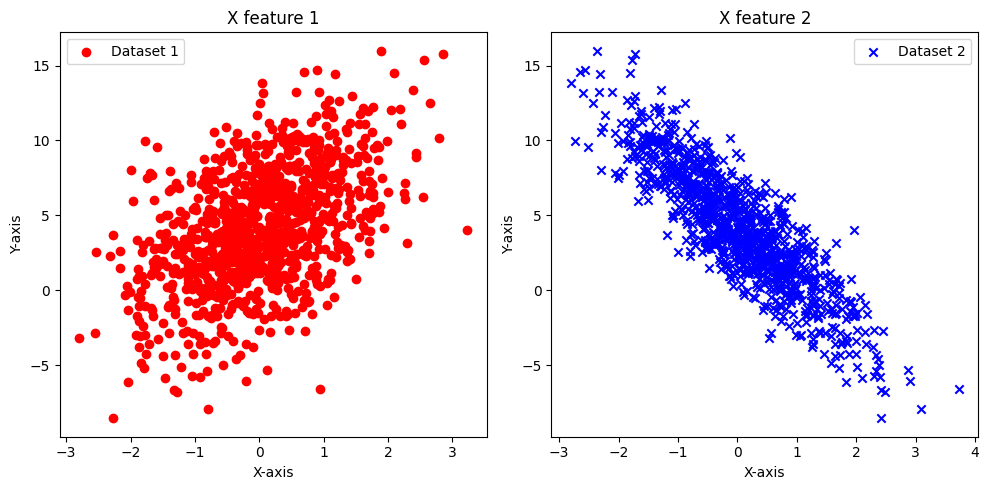

In [9]:
import matplotlib.pyplot as plt

# 创建一个 1x2 的子图布局（即一行两列）
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 在第一个子图上绘制第一个散点图
# features和labels是包含梯度，计算图的tensor类型，需要使用detach()函数分离以后才能转换成numpy类型
axs[0].scatter(features[:,(0)].detach().numpy(),labels.detach().numpy(), c='r', marker='o', label='Dataset 1')
axs[0].set_title('X feature 1')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].legend()

# 在第二个子图上绘制第二个散点图
axs[1].scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(), c='b', marker='x', label='Dataset 2')
axs[1].set_title('X feature 2')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].legend()

# 调整子图间的距离
plt.tight_layout()
plt.show()

> 随机打乱数据与读取

* 将样本数据随机打乱并且生成大小为batch_size的小批量，每个小批量包含一组特征和标签

In [12]:

def data_iter(batch_size,features,labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  #生成随机顺序
  random.shuffle(indices)
  for i in range(0,num_examples,batch_size):
    batch_indices = torch.tensor(
        indices[i:min(i+batch_size,num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]


利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

> 批量样本和标签的维度显示
* 读取第一个小批量数据

In [13]:
batch_size = 10

for x , y in data_iter(batch_size, features, labels):
  print(x, "\n", y)
  break


tensor([[-0.4694,  0.2003],
        [-0.6583,  1.3610],
        [ 1.8596,  0.7844],
        [ 1.3908, -0.7255],
        [-1.4631,  2.0974],
        [-0.2266,  1.3113],
        [ 0.9016, -2.5581],
        [-1.7769,  0.0632],
        [-1.4896, -0.2130],
        [-0.2349, -0.8251]]) 
 tensor([[ 2.5792],
        [-1.7439],
        [ 5.2521],
        [ 9.4497],
        [-5.8571],
        [-0.7124],
        [14.7014],
        [ 0.4309],
        [ 1.9431],
        [ 6.5349]])


* 当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。

* 上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。

*  例如，它**要求我们将所有数据加载到内存中，并执行大量的随机内存访问**。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据

> 初始化模型参数
  
* w 随机初始化，使用正态分布(0,0.01)
* b 初始化为0

In [15]:
w = torch.normal(0, 0.01, size=(2,1),requires_grad=True)
b = torch.zeros(1, requires_grad=True)

> 定义模型


In [18]:
def linreg(x, w, b):
  """线性回归模型"""
  return torch.matmul(x,w) +b
  #torch.matmul()和torch.mm()的区别mm只能计算轴数为2的数据，matmul()可以计算更多轴

> 定义损失函数

* 采用MSE均方误差

In [20]:
def squared_loss(y_hat, y):
  return (y_hat - y.reshape(y_hat.shape))**2/2

> 定义优化算法


接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [21]:
def sgd(params, lr, batch_size):
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

> 训练

在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000001
epoch 2, loss 0.000001
epoch 3, loss 0.000001


In [28]:
print(f'w的真实值：{true_w}, w的估计值{w}')
print(f'b的真实值：{true_b},b的估计值{b}')
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的真实值：tensor([ 2.0000, -3.4000]), w的估计值tensor([[ 2.0000],
        [-3.4000]], requires_grad=True)
b的真实值：4.2,b的估计值tensor([4.1999], requires_grad=True)
w的估计误差: tensor([ 4.3511e-05, -4.7684e-06], grad_fn=<SubBackward0>)
b的估计误差: tensor([7.0095e-05], grad_fn=<RsubBackward1>)
